<span style="color:red">**Membres du groupe / emails**</span> 
- (1) Imed KERAGHEL : keraghel.imed19@gmail.com
- (2) Oussama HEBROUNE : oussamaheb@gmail.com


## 1. Introduction
Dans le cadre du Master 2 MLDS (promotion 2020-2021) de l’université de Paris, il nous a été demandé, lors du cours **Big Data**, d’étudier un jeu de données en utilisant l'APIs d’Apache Spark, aﬁn de tester quelques approches de Clustring. Plus particulièrement, nous utiliserons Spark SQL qui permet de travailler avec des DataFrames, ainsi que Spark MLlib qui permet d’utiliser des fonctionnalités de Machine Learning. Ce projet consiste à regrouper des documents textuels tel que les
documents qui partagent la même thématique se retrouvent dans le même groupe, et les documents qui portent sur des sujets très différents se trouvent dans des groupes différents.

## 2. Mise en place de l’environnement de travail


In [1]:
%%capture

# Installer java8
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# Télécharger Spark (la version 3.0.2)
!wget -q https://downloads.apache.org/spark/spark-3.0.2/spark-3.0.2-bin-hadoop2.7.tgz

# Dézipper le fichier déjà télécharger
!tar xf spark-3.0.2-bin-hadoop2.7.tgz

# Installer findspark 
!pip install -q findspark

# Mettre en place les variables d'environnement nécessaires
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.2-bin-hadoop2.7"
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.apache.spark:spark-avro_2.12:3.0.1 pyspark-shell'

import findspark
findspark.init("spark-3.0.2-bin-hadoop2.7")

In [2]:
%%capture

# Pour utiliser l'API RDD, utiliser l'objet sc
from pyspark import SparkContext, SparkConf
conf = SparkConf().setAppName("mon application").setMaster("local[4]")
sc = SparkContext(conf=conf)

# Pour utiliser l'API Spark SQL, utiliser l'objet spark
from pyspark.sql import SparkSession, Row
spark = SparkSession.builder.config(conf=conf).getOrCreate()

# 3. Préparation de données

Comme dans tous les problèmes d’apprentissage automatique, l’entrainement et l’évaluation d’un modèle s’effectue au moyen d’un ensemble de données comportant des exemples déjà labelisés. Dans notre cas, nous travaillons sur le dataset **20Newsgroups**. Il s'agit d'est une collection d’environ 20 000 documents de groupe de discussion, partitionnés de manière presque égale sur 20 groupes de discussion. Nous avons utilisé **deux classes** parmi les vingt classes qui constituent en réalité le dataset.

La première étape de ce travail consiste à récupérer ce jeu de données (en format brut), et de réaliser ensuite, ce qu’on appelle le **Data Wrangling**, aussi appelé préparation de données en Self-Service, ce dernier est le processus qui permet, à partir des données brutes de les découvrir, structurer, nettoyer, valider et de publier les résultats dans un format adapté à l’analyse des données.

Dans un premier temps, nous avons inspecté les ﬁchiers fournis aﬁn de découvrir les structures, les contenus et la qualité des données brutes. Le but était de voir et de comprendre la nature des données avant de les manipuler. Après, nous avons réalisé l’étape de la transformation des données. L’objectif était de ranger les données dans un format structuré (spark DataFrame). Vu la taille de données, nous nous sommes limités aux deux classes : *alt.atheism* et *rec.sport.baseball*.



### a, b. Téléchargement et décompression de données

In [3]:
# download data
!wget -q http://qwone.com/~jason/20Newsgroups/20news-19997.tar.gz

# unzip it
!tar xf 20news-19997.tar.gz

### c. Charger les données dans deux variables de type RDD

In [4]:
rdd_atheism = sc.wholeTextFiles("/content/20_newsgroups/alt.atheism/*")
rdd_baseball = sc.wholeTextFiles("/content/20_newsgroups/rec.sport.baseball/*")

### d. Séparer le corps du message de l’entête.

In [5]:
def head_body_split(s):
    """
    Une fonction qui permet de séparer le corps du message de l’entête
    """
    # Utilisation de try except : certains messages ne comportent pas la lignes (Lines ...)
    try:
        a = s[1].find('Lines')
        lines = int(s[1][a+7:a+12].split()[0])
        h = s[1].count('\n') - lines
        return s[0], s[1].rsplit('\n')[:h], s[1].rsplit('\n')[h + 1:]
    except:
        splits = s[1].split('\n\n',1)
        return s[0], splits[0], splits[1]

# Appliquer la fonction head_body_split() sur les RDDs
rdd_atheism = rdd_atheism.map(head_body_split)
rdd_baseball = rdd_baseball.map(head_body_split)

### e. Extraire quelques champs de l’entête

In [6]:
def fields(f):
    s = f[1]
    key = f[0]
    Category= ''; From = ''; Message_ID = ''; Subject = ''; Organization = ''; References = ''; Date = ''; Sender = ''; Reply_To = '';
    for l in range(len(s)):
        Category = key[28:].split('/')[0]
        Key = key[28:].split('/')[1]
        if s[l][:4] == 'From':
            From = s[l][6:]
        if s[l][:10] == 'Message-ID':
            Message_ID = s[l][12:]
        if s[l][:7] == 'Subject':
            Subject = s[l][9:]
        if s[l][:12] == 'Organization':
            Organization = s[l][14:]
        if s[l][:10] == 'References':
            References = s[l][12:]
        if s[l][:4] == 'Date':
            Date = s[l][6:]
        if s[l][:6] == 'Sender':
            Sender = s[l][8:]
        if s[l][:8] == 'Reply-To':
            Reply_To = s[l][10:]
    Body = ' '.join(f[2])
    return Key, Category, From, Message_ID, Subject, Organization, References, Date, Sender, Reply_To, Body

# Appliquer la fonction fields() sur les RDDs
rdd_atheism = rdd_atheism.map(fields)
rdd_baseball = rdd_baseball.map(fields)

### f. Fusionner les deux RDD

La fonction *union()* permet de fusionner 2 RDDs

In [7]:
rdd_joined = rdd_atheism.union(rdd_baseball)

### g. Transformer le nouveau RDD obtenu pour que chaque élément soit de type pyspark.sql.Row

In [8]:
t = rdd_joined.collect()[1001]

def to_Row(t):
  return Row(Key= t[0], Category= t[1], From= t[2], Message_ID= t[3], Subject= t[4], 
             Organization= t[5], References= t[6], Date= t[7], Sender= t[8], 
             Reply_To= t[9], Body= t[10])

test = rdd_joined.map(to_Row)

### h. Créer un objet de type DataFrame à partir du RDD précédent

In [9]:
df = spark.createDataFrame(test)

Visualiser le DataFrame

In [10]:
df.show(5)

+-----+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|  Key|   Category|                From|          Message_ID|             Subject|        Organization|          References|                Date|              Sender|            Reply_To|                Body|
+-----+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|54259|alt.atheism|Alan.Olsen@p17.f4...|<735424748.AA0043...|        Albert Sabin|                    |                    |Wed, 21 Apr 1993 ...|postmaster@theros...|                    |BR> From: wpr@atl...|
|54165|alt.atheism|halat@pooh.bears ...|<30137@ursa.bear....|Re: The nonexista...|                    |<1pibs8$170@usene...|16 Apr 93 21:25:2...|       news@bear.co

### i, j Sauvegarder la DataFrame au format Avro/Parquet

In [11]:
df.write.parquet('data_parquet.parquet')
df.write.format("avro").save("data_avro.avro")

# 4. Analyse descriptive

### a. Vérifier qu’on a bien deux catégories différentes de documents

In [12]:
df.groupby('Category').count().show()

+------------------+-----+
|          Category|count|
+------------------+-----+
|rec.sport.baseball| 1000|
|       alt.atheism| 1000|
+------------------+-----+



### b. Donner le nombre d’organisations différentes

In [13]:
df.select(df.Organization).distinct().count()

485

### c. Suivant les champs extraits, donner d’autres statistiques descriptives

### Les organisations

In [18]:
df.select(df.Organization).distinct().take(5)

[Row(Organization='University of Wales College of Cardiff, Cardiff, WALES, UK.'),
 Row(Organization='Brownian Motion Inc.'),
 Row(Organization='University of New Hampshire  -  Durham, NH'),
 Row(Organization='Brotherhood Of Breath'),
 Row(Organization='Yale University Computer Science Dept., New Haven, CT 06520-2158')]

### WordCloud

Le graphique nuage de mots, WordCloud en anglais, permet de visualiser des données textuelles. Les valeurs de texte sont aﬃchées selon une taille basée sur l’importance ou encore le contexte. La ﬁgure suivante montre le WordCloud des données 20newsgroups.

(-0.5, 499.5, 249.5, -0.5)

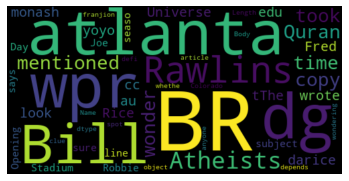

In [19]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

df_res_pandas = df.toPandas()
text = df_res_pandas['Body']
del df_res_pandas

stopwords = set(STOPWORDS)
stopwords.add("https")
stopwords.add("xa0")
stopwords.add("xa0'")
stopwords.add("bitly")
stopwords.add("bit")
stopwords.add("ly")
stopwords.add("twitter")
stopwords.add("pic")

wordcloud = WordCloud(
    background_color = 'black',
    width = 500,
    height = 250,
    stopwords = stopwords).generate(str(text))

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")

### Les plus grands émetteurs de mails 

In [20]:
df.groupby('From').count().orderBy('count', ascending=False).show(10)

+--------------------+-----+
|                From|count|
+--------------------+-----+
|livesey@solntze.w...|   70|
|keith@cco.caltech...|   56|
|kmr4@po.CWRU.edu ...|   42|
|frank@D012S658.uu...|   41|
|mathew <mathew@ma...|   38|
|I3150101@dbstu1.r...|   35|
|bil@okcforum.osrh...|   32|
|tedward@cs.cornel...|   25|
|sandvik@newton.ap...|   25|
|bobbe@vice.ICO.TE...|   24|
+--------------------+-----+
only showing top 10 rows



## 5. Transformation du texte et clustering

Cette étape consiste à nettoyer les données, car ces données textuelles ont pour particularité d’être non structurées, et souvent l’information cherchée est perdue au milieu d’une grande quantité d’information. Il y a d’assez faibles chances pour que deux textes même lorsqu’ils expriment le même message, soient rédigés exactement avec les mêmes mots dans le même ordre. En eﬀet, les données textuelles sont souvent bruitées (fautes de frappe), ambiguës (synonymie, polysémie) et d’une grande dimension.

Pour pallier ce problème, une série de traitements a été appliquée aﬁn de nettoyer les données :

- **tokenisation** et transformation de l’ensemble du texte en **lettres minuscules**
- retrait des **mots vides** (stopwords) et des **caractères spéciaux** (les ponctuations, les parenthèses, les chiﬀres, etc.)
- application de la fonction **HashingTF** : HashingTF est un transformateur qui prend des séries de termes et convertit ces ensembles en Vecteurs de caractéristiques de longueur fixe.

In [21]:
import re
import string
from itertools import chain

def clean_text_step_1(word:str)->str:

    """
    Cette fonction permet de nettoyer le text : Mettre le texte en minuscules, supprimer le texte entre parenthèses, 
    supprimer la ponctuation et les mots contenant des chiffres.
    """

    word = word.lower()
    word = re.sub('\[.*?\]', '', word)
    word = re.sub('[%s]' % re.escape(string.punctuation), '', word)
    word = re.sub('\w*\d\w*', '', word)
    word = re.sub('>', '', word)
    word = re.sub('|>', '', word)
    word = word.strip()
    return word

def clean_text_step_2(word:str)->str:
    """ 
    Cette fonction permet de complèter la fonction clean_text_step_1()
    """
    word = clean_text_step_1(word)
    word = re.sub('[‘’“”…]', '', word)
    word = re.sub('\n', '', word)
    word = word.strip()
    
    return word

In [22]:
%%capture

from pyspark.ml.feature import HashingTF, Tokenizer, StopWordsRemover
import nltk
from nltk.corpus import stopwords, wordnet

nltk.download('stopwords')
nltk_stopwords = list(set(stopwords.words("english")))

df_pandas = df.toPandas()
df_pandas.Body = df_pandas.Body.apply(lambda x: " ".join(clean_text_step_2(word) for word in x.split() if len(word) > 3))
df = spark.createDataFrame(df_pandas)

# Appliquer la tokenisation
tokenizer = Tokenizer(inputCol='Body', outputCol='words_token')
df_words_token = tokenizer.transform(df).select('Key', 'words_token', 'Category')
     
# Retirer les stopwords
remover = StopWordsRemover(stopWords = nltk_stopwords, inputCol='words_token', outputCol='words_clean')
df_words_no_stopw = remover.transform(df_words_token).select('Key', 'words_clean', 'Category')

# Appliquer HashingTF
hashingTF = HashingTF(inputCol='words_clean', outputCol="features").setNumFeatures(2000)
df_words = hashingTF.transform(df_words_no_stopw)

In [23]:
df_words.show(5)

+-----+--------------------+-----------+--------------------+
|  Key|         words_clean|   Category|            features|
+-----+--------------------+-----------+--------------------+
|54259|[wpratlantadgcom,...|alt.atheism|(2000,[2,54,60,69...|
|54165|[atheists, mentio...|alt.atheism|(2000,[152,293,29...|
|54257|[took, time, copy...|alt.atheism|(2000,[7,23,37,79...|
|53273|[wonder, universe...|alt.atheism|(2000,[2,28,80,99...|
|53120|[dariceyoyoccmona...|alt.atheism|(2000,[57,59,74,7...|
+-----+--------------------+-----------+--------------------+
only showing top 5 rows



## KMeans avec pyspark

In [24]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

from random import seed
seed(2021)

# Entraîner le modèle
kmeans = KMeans().setK(2).setSeed(1).setFeaturesCol('features')
model = kmeans.fit(df_words)

# Predictions
predictions = model.transform(df_words)

In [25]:
transformed = model.transform(df_words).select('Key', 'prediction')
rows = transformed.collect()
df_pred = spark.createDataFrame(rows)
kmeans_spark = [int(row.prediction) for row in df_pred.select("prediction").collect()]

## kmeans avec scikit-learn

In [26]:
%%capture
from textblob import Word
nltk.download('wordnet')

# Preprocessing
df_pandas.Body = df_pandas.Body.apply(lambda x: " ".join(x for x in x.split() if x not in nltk_stopwords))
df_pandas.Body = df_pandas.Body.apply(lambda x: " ".join(Word(word).lemmatize() for word in x.split()))

# données et labels
data = df_pandas.Body
label = df_pandas.Category.astype('category').cat.codes

In [27]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.cluster import KMeans
import numpy as np

seed(2021)

# Créer un objet CountVectorizer avec un nombre max de 2000 features
count_vect = CountVectorizer(max_features=2000)

# Appliquer une pondération tfidf
tfidf_transformer = TfidfTransformer()

# Création de la matrice doc_termes
X_train_counts = count_vect.fit_transform(data)
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

# Appliquation de KMeans avec un nombre de clusters égale à 2
kmeans = KMeans(n_clusters=2, random_state=2).fit(X_train_tfidf)
y_kmeans = kmeans.predict(X_train_tfidf)

## Analyse de résultats

Nous avons cherché à améliorer les performances en faisant varier les paramètres de chaque modèle.

L'information mutuelle normalisée (**NMI**) permet de mesurer la quantité d’information d’une partition contenue dans une seconde partition. Ainsi, lorsque cette mesure entre deux partitions est au maximum, elles sont identiques, i.e. très corrélées. Cette mesure est indépendante des valeurs des labels : une permutation des valeurs ne changera en rien la valeur du score. 

On constate que l'implémentation scikit-learn de kmeans fait beaucoup mieux (NMI égale à 0.8) que celle de pyspark(NMI proche de 0). On remarque aussi que les groupes formés sont beaucoup plus équilibrés par rapport à ceux de pyspark.


In [28]:
df_pred.groupby('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         0| 1997|
|         1|    3|
+----------+-----+



In [29]:
np.unique(y_kmeans, return_counts=True)

(array([0, 1], dtype=int32), array([ 967, 1033]))

In [30]:
from sklearn.metrics import normalized_mutual_info_score, adjusted_mutual_info_score 
print(f"NMI de kmeans-sklearn  {normalized_mutual_info_score(label, y_kmeans)}")

NMI de kmeans-sklearn  0.8044301842938406


In [31]:
print(f"NMI de kmeans-spark  {normalized_mutual_info_score(label, kmeans_spark)}")

NMI de kmeans-spark  0.002955276020780368


## 5. Implémentation de K-means unidimensionnel

**K-means** est un algorithme non supervisé de clustering non-hiérarchique. Il permet de regrouper en *K* clusters distincts les observations du jeu de données. Ainsi, les données similaires se retrouveront donc dans le même cluster. Par ailleurs, une observation ne peut se retrouver que dans un cluster à la fois (exclusivité d’appartenance). Une même observation, ne pourra donc, appartenir à deux clusters différents.

**Principe de kmeans** : on tire aléatoirement *k* points qui forment les centres initiaux des classes, puis on va répéter jusqu’à convergence, i.e si le critère de l’inertie intra-classe ne décroit pas d’une manière significative) : 
- affecter chaque point à la classe dont il est le plus proche du centre de gravité (en prenant la distance euclidienne comme mesure)

- recalculer les centres de gravité


Pour un nombre donné de cluster K et un ensemble de N vecteurs xi tel que : 

$$
xi,i∈[1,N]
$$
K-means a pour objectif de minimiser le critère suivant :

$$
W(z,\mu) = \sum_{k = 1}^{K} \sum_{i = 1}^{N} z_{ik} \| x_i - \mu_k\|^2
$$

En prenant en compte la distance euclidienne (au carré):

 $$d^2\left( x, \mu\right)   = {\sum _{i=1}^{P}  \left( x_{i} - \mu_{i}\right)^2 } $$

### Les fonctions que nous avons implémentées

In [32]:
def avg(rdd)->tuple:
    """
    Une fonction qui permet de calculer le centre de gravité de chaque cluster
    """

    cluster_id = rdd[0][0]
    average = rdd[0][1]/rdd[1][1]

    return cluster_id , average


def compute_centroids(points, clusters_ids):
    """
    Cette fonction retourne un RDD de couples (cluster_id, moyenne)
    """
    
    # Appliquer la fonction zip() 
    zipped_rdd = clusters_ids.zip(points)

    # calculer la moyenne de chaque cluster
    sum_by_cluster_id = zipped_rdd.groupByKey().mapValues(sum)
    count_by_cluster_id = zipped_rdd.groupByKey().mapValues(len)
    sum_and_count = sum_by_cluster_id.zip(count_by_cluster_id)
    average = sum_and_count.map(avg)
        
    return average


def assign_clusters(points, centroids):
    """
    Une fonction qui permet d'affecter chaque point au cluster dont il est le plus proche du centre de gravité
    En se basant sur la distance euclidienne
    """

    liste_of_centroids = centroids.collect()
    assignments = points.map(lambda x: squared_distances(x, liste_of_centroids)).map(np.argmin)
    
    return assignments


def squared_distances(p, liste_of_centroids)->list:
    """
    Une fonction qui permet de calculer la distance euclidienne
    """
    dist = [np.square(p - i[1]) for i in liste_of_centroids]
    
    return dist

## Tester le modèle

In [33]:
%%capture
from sklearn.datasets.samples_generator import make_blobs

# Générer un data set avec 5 classes
X, reel_clusters = make_blobs(n_samples=400, centers=5,
                       cluster_std=0.60, random_state=0)

# Préparer les données d'entraînement 
points = X[:, 1] 
clusters_ids = np.random.randint(0, 5, 400)

# Création des RDD
clusters_ids = sc.parallelize(clusters_ids)
points = sc.parallelize(points)

In [34]:
# Tester le modèle avec un nombre d'itération égale à 30
for i in range(30):
  
  # Affecter chaque point 
  centroids = compute_centroids(points, clusters_ids)
  
  # Recalculer les centres
  clusters_ids = assign_clusters(points, centroids)

# Calculer la NMI
normalized_mutual_info_score(reel_clusters, clusters_ids.collect())

0.8743311654759407

## Implémentation de K-means multidimensionnel

### Mettre à jour les fonctions *squared_distances()* et *assign_clusters()* afin de prendre en compte le cas multidimensionnel

In [35]:
def squared_distances_multi(point, liste_of_centroids)->list:
    """
    Une fonction qui permet de calculer la distance euclidienne dans le cas multidimensionnel
    """
    dist = [np.square(np.linalg.norm(point - i[1])) for i in liste_of_centroids]

    return dist


def assign_clusters_multi(points, centroids):
    """
    Une fonction qui permet d'affecter chaque point au cluster dont il est le plus proche du centre de gravité, 
    dans le cas multidimensionnel. En se basant sur la distance euclidienne
    """
    liste_of_centroids = centroids.collect()
    assignments = points.map(lambda x: squared_distances_multi(x, liste_of_centroids)).map(np.argmin)
    
    return assignments

## Tester le version multidimensionnelle de Kmeans 

In [36]:
from sklearn.datasets.samples_generator import make_blobs
points, reel_clusters = make_blobs(n_samples=400, centers=5,
                       cluster_std=0.60, random_state=0)

clusters_ids = np.random.randint(0, 5, 400)
clusters_ids = sc.parallelize(clusters_ids)
points = sc.parallelize(points)

for i in range(30):
  centroids = compute_centroids(points, clusters_ids)
  clusters_ids = assign_clusters_multi(points, centroids)


normalized_mutual_info_score(reel_clusters, clusters_ids.collect())

0.8972495397346943

## 6. Implémentation de Spherical k-means

Le **Spherical k-means** se base essentiellemnt sur **la similarité cosinus**, cette dernière permet de calculer la similarité entre deux vecteurs à N dimensions en déterminant le cosinus de l'angle entre eux. 

$$cos\left( A, B\right) = \frac{ A \cdot B}{\|A\| \|B\|} $$

Comme la valeur de *cosinus* est comprise dans l'intervalle [-1,1], la valeur -1 indiquera des vecteurs résolument opposés, 0 des vecteurs indépendants (orthogonaux) et 1 des vecteurs similaires (colinéaires de coefficient positif). Les valeurs intermédiaires permettent d'évaluer le degré de similarité.




### Mettre à jour la fonction *assign_clusters_multi()* et implémentation de la fonction *cosine_similarity()*

In [37]:
from numpy import dot
from numpy.linalg import norm


def assign_clusters_spherical(points, centroids):
    """
    Une fonction qui permet d'affecter chaque point au cluster dont il est le plus proche du centre de gravité, 
    dans le cas multidimensionnel. En se basant sur la similarité cosinus
    """
    list_of_centroids = centroids.collect()
    assignments = points.map(lambda point: cosine_similarity(point, list_of_centroids)).map(np.argmax)
    
    return assignments


def cosine_similarity(p, l)->list:
    """
    Une fonction qui permet de calculer la distance cosinus entre 2 vecteurs
    """
    dist = [dot(p, i[1])/(norm(p) * norm(i[1])) for i in l]
    
    return dist

## Tester le modèle avec les données 20newsgroups

In [38]:
from random import seed
seed(2021)
points = X_train_counts.toarray()
points = sc.parallelize(points)
clusters_ids = np.random.randint(0, 2, 2000)
clusters_ids = sc.parallelize(label)

In [39]:
for i in range(10):
    centroids = compute_centroids(points, clusters_ids)
    clusters_ids = assign_clusters_spherical(points, centroids)

In [40]:
print(f"NMI : {normalized_mutual_info_score(label, clusters_ids.collect())}")

NMI : 0.6797975201544831


## Comparer notre implémentation avec celle de coclust

Installer la package coclust

In [41]:
%%capture
!pip install coclust

Entrainer le modèle

In [42]:
%%capture
from random import seed
seed(2021)
from coclust.clustering.spherical_kmeans import SphericalKmeans

model = SphericalKmeans(n_clusters=2, max_iter=50, random_state=2021)
model.fit(X_train_counts)

predicted_row_labels = model.row_labels_

In [43]:
print(f"NMI : {normalized_mutual_info_score(predicted_row_labels, label)}")

NMI : 0.8114571801465591


En évaluant les performances de chaque modèle sur le data set initial. On constate que l'implémentation de coclust fait mieux (NMI égale à 0.81) que notre implémentation (NMi égale à 0.68), et si on se base sur les métriques classiques comme le taux d'erreur par exemple, il ne semble pas y avoir une grosse différence de performances entre les deux modèles (3% vs 6%).

In [44]:
from sklearn.metrics import confusion_matrix

cm_spherical_coclust = confusion_matrix(predicted_row_labels, label)

def swap(matrix_row, x, y):
      """
      Une fonction qui permet de faire une permutation de valeurs dans une matrice de confusion
      """
      index_Y = np.where(matrix_row == y)
      val_X = matrix_row[x]
      matrix_row[x] = y
      matrix_row[index_Y] = val_X
      
      return matrix_row

def reorder_mat(mat):
    """
    Une fonction qui permet de réarranger une matrice de confusion
    Elle ne marche que dans le cas binaire (matrice de dim 2X2)
    """
    for i in range(mat.shape[0]):
        row_I = mat[i,]
        y = max(row_I)
        mat[i,] = swap(row_I, i, y)
    
    return (mat)

cm_spherical_coclust = reorder_mat(cm_spherical_coclust)
accuracy = np.trace(cm_spherical_coclust) / np.sum(cm_spherical_coclust)
print("Taux d'erreur (coclust) : {0:.0%}".format(1 - accuracy))

Taux d'erreur (coclust) : 3%


In [45]:
cm_spherical = confusion_matrix(label, clusters_ids.collect())
cm_spherical = reorder_mat(cm_spherical)
accuracy = np.trace(cm_spherical) / np.sum(cm_spherical)
print("Taux d'erreur (de notre implémentation) : {0:.0%}".format(1 - accuracy))

Taux d'erreur (de notre implémentation) : 6%


## 7. Autres classifications

## Classification non supervisée


### LDA

Le modèle **Latent Dirichlet Allocation** (LDA) est un modèle probabiliste génératif qui permet de décrire des collections de documents de texte. Ce modèle fait partie d’une catégorie de modèles appelés **topic models**, qui cherchent à découvrir des structures thématiques cachées dans une collection de documents.

In [46]:
from pyspark.ml.clustering import LDA

# Entrainr un modèle LDA avec 2 k = 2
lda = LDA(k=2, maxIter=10).setSeed(2021).setFeaturesCol('features')
model = lda.fit(df_words)

# Décrire les topics
topics = model.describeTopics(3)
print("The topics described by their top-weighted terms:")
topics.show(truncate=False)

# Afficher le result
transformed = model.transform(df_words)

The topics described by their top-weighted terms:
+-----+----------------+-----------------------------------------------------------------+
|topic|termIndices     |termWeights                                                      |
+-----+----------------+-----------------------------------------------------------------+
|0    |[911, 1372, 157]|[0.008692852144602867, 0.00849649136449359, 0.00720234016123637] |
|1    |[1372, 911, 157]|[0.07423722688124325, 0.006827680241927799, 0.006470560291382963]|
+-----+----------------+-----------------------------------------------------------------+



### Bisecting KMeans

Le **Bisecting KMeans** est une approche hybride qui combine le Clustering hiérarchique descendant avec le Clustering K-means. Au lieu de partitionner l'ensemble de données en K groupes à chaque itération, cet algorithme divise chaque groupe en deux sous-groupes en utilisant k-means jusqu'à l'obtention de k groupes.


In [47]:
from pyspark.ml.clustering import BisectingKMeans

bkm = BisectingKMeans().setK(2).setSeed(1).setFeaturesCol('features')
model = bkm.fit(df_words)

# Prédictions
predictions = model.transform(df_words)

In [48]:
transformed = model.transform(df_words).select('Key', 'prediction')
rows = transformed.collect()

df_pred = spark.createDataFrame(rows)
df_pred.groupby('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         0| 1997|
|         1|    3|
+----------+-----+



## Comparaison de résultat

On peut facilement remarquer que BisectingKMeans ne fait pas mieux que la version standard de Kmeans déjà implémentée dans pyspark, on remarque aussi que les classes formées sont déséquilibrées.

## Classification supervisée

### Random Forest

Le **random forest** est un algorithme qui se base sur l’assemblage d’arbres de décision. Il est assez intuitif à comprendre, rapide à entraîner et il produit des résultats généralisables.

Un random forest est constitué d'un ensemble d'arbres de décision indépendants. Chaque arbre dispose d'une vision parcellaire du problème du fait d'un double tirage aléatoire :

- un tirage aléatoire **avec remplacement** sur les observations (les lignes de votre base de données). Ce processus s'appelle le **tree bagging**,
- un tirage aléatoire sur les variables (les colonnes de votre base de données). Ce processus s'appelle le **feature sampling**.

A la fin, tous ces arbres de décisions indépendants sont assemblés. La prédiction faite par le random forest pour des données inconnues est alors la moyenne (ou le vote, dans le cas d'un problème de classification) de tous les arbres.




In [49]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

data = df_words.withColumnRenamed('Category', 'label')
data = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(data).transform(data)

# Diviser les données en 2 ensembles : apprentissage et test
(trainingData, testData) = data.randomSplit([0.7, 0.3])

featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(data)

# Entraîner le modèle
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="features", numTrees=100)

pipeline = Pipeline(stages=[featureIndexer, rf])

model = pipeline.fit(trainingData)

# Prédictions.
predictions = model.transform(testData)

# Calculer le taux d'erreur
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

Test Error = 0.0779661


### Gradient Boosting

Le **BOOSTING** est une technique ensembliste qui consiste à agréger des modèles élaborés séquentiellement sur un échantillon d’apprentissage dont les poids des individus sont corrigés au fur et à mesure. Les classifieurs sont pondérés selon leurs performances.

**Le gradient boosting** utilise le gradient de la fonction de perte pour le calcul des poids des individus lors de la construction de chaque nouveau modèle. Cela ressemble un peu à la descente de gradient pour les réseaux de neurones.

GBM utilise généralement des arbres CART et on peut personnaliser l’algorithme en utilisant différents paramètres, différentes fonctions.





In [50]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

(trainingData, testData) = data.randomSplit([0.7, 0.3])

gbt = GBTClassifier(labelCol="indexedLabel", featuresCol="features", maxIter=100, minInstancesPerNode=10)

pipeline = Pipeline(stages=[featureIndexer, gbt])

model = pipeline.fit(trainingData)

predictions = model.transform(testData)

evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

Test Error = 0.067474


### SVM

Les **Support Vector Machines** (SVM) sont une famille d’algorithmes d‘apprentissage supervisé permettant de résoudre des problèmes de classification et de régression. Leur principe est simple : ils ont pour but de séparer les données en classes (dans un problème de classification bien sûr) à l’aide d’une frontière aussi simple que possible, de telle façon que la distance entre les différents groupes de données et la frontière qui les sépare soit maximale.

In [51]:
from pyspark.ml.classification import LinearSVC
seed(2021)
training = StringIndexer(inputCol="Category", outputCol="label").fit(df_words).transform(df_words)
lsvc = LinearSVC(maxIter=20, regParam=0.1)
(trainingData, testData) = training.randomSplit([0.7, 0.3])
lsvcModel = lsvc.fit(trainingData)
predictions = lsvcModel.transform(testData)
y_predicted = np.array([int(row.prediction) for row in predictions.select("prediction").collect()])
y_reel = np.array([int(row.label) for row in testData.select("label").collect()])
accuracy = sum(y_reel == y_predicted)/len(y_predicted)
print("Test Error = %g" % (1.0 - accuracy))

Test Error = 0.0474576


## Comparaison de résultats

Les résultats illustrés par démontrent la performance de modèle **SVM** dans la classiﬁcation de données, avec un taux d’erreur de 5%. Cependant, **Spherical-Kmeans** obtient un meilleur taux d'erreur (3%), et apparaît donc comme le meilleurs classiﬁeur (malgré le fait qu'il s'agit d'un algorithme de Clustering).

